# Rationale

We want to perform inference on the parameters $\boldsymbol{z}$ of our forward model, which is defined as the solution
of the linear Poisson equation with homogeneous Dirichlet boundary conditions, namely

$$\Delta u(\boldsymbol{x}; \boldsymbol{z}) = - f(\boldsymbol{x}; \boldsymbol{z})\quad \forall\boldsymbol{x}\in\Omega$$

$$u(\boldsymbol{x}; \boldsymbol{z}) = 0 \quad\forall\boldsymbol{x}\in\partial\Omega$$

Since the posterior is not known analytically, we perform a Metropolis-Hasting algorithm both with the high-fidelity
model (computationally very expensive), and the low-fidelity model (less expensive, but introducing an approximation)
for comparison.

Ultimately we simulate draws from the posterior through the multi_fidelity approach; although we still rely on an
approximation, we correct the surrogate iteratively to get better and better proxies of the model, while retaining
a sufficiently low computational overhead

## Imports

In [18]:
import fenics

import numpy as np
import chaospy as cpy
import matplotlib.pyplot as plt
import seaborn as sns

from chaospy import Uniform
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process.kernels import RBF
from scipy.special import logit

from source.models.gaussian_processes import GPSurrogate
from source.models.high_fidelity import HighFidelityModel
from source.models.chaos_expansion import PCESurrogate
from source.distributions.cond_inv_gamma import CondInvGamma
from source.distributions.gauss_distr import GaussDensity
from source.distributions.uniform_distr import UnifDistr
from source.utils.diagnostics import run_and_track, diagnostics_report, visual_inspection
from source.utils.diagnostics import surface_plot, wireframe_plot, points_plot


The following class contains a parametric implementation of the aforementioned differential problem and wraps
a FEniCS solver to evaluate the (logarithm of the solution); you can run

```help(PoissonEquation)```

for more information.

We can use an instance of `PoissonEquation` as callable object in order to obtain the value of the solution
in the spatial nodes of interest.

In [2]:
from source.problems.poisson_equation_base import PoissonEquation

In [19]:
fenics.set_log_level(30)
np.random.seed(1226)
sns.set_style('whitegrid')

First we define some useful variables: if you want to test our implementation with different settings,
modify the following.

In [5]:
# problem parameters
dim = 2
tol = 1e-5                              # tol is used for not drawing nodes from the boundary
num_data = 100                          # sample's dimension of data collected
noise_sigma = .3                        # since we generate the data we add some artificial noise
logit_true_z = np.array([.25, .75])

In [6]:
# distribution parameters
prior_means = np.array([0., 0.])
prior_sigmas = np.array([1.5, 1.5])
proposal_sigma = .05
gamma_parameters = np.array([1., 1.])

In [7]:
# MCMC parameters
samples = 50000
subchain_len = 1000
upper_th = 1e-4
error_th = 1e-2
init_z = np.array([.0, .0])
init_sigma = 1.
init_radius = .1
rho = .9
burn = 2000

In [8]:
# surrogate parameters
use_gpr = True
quad_points = 20
multi_fidelity_q = 12

We initialize the forward model as the solution of the bidimensional Poisson equation with
homogeneous Dirichlet boundary conditions.

We choose a much finer mesh to generate the data than to run the MCMC, in order to avoid "inverse crimes".

In [9]:
# definition of the forward model for data generation - finer grid to avoid inverse crimes
equation = 'exp(-100*(pow(x[0] - param0, 2) + pow(x[1] - param1, 2)))'
data_gen_forward_model = PoissonEquation(
    np.array([128, 128]), equation,
    np.array([.5, .5]), '0', reparam=True)

Below are some helpful functions to constuct visualizations of the true solution and generated data.

In [10]:
def pressure(xx, yy):
    xy = np.array([xx.flatten(), yy.flatten()])
    zz = np.array([np.exp(-100 * ((x_ - logit_true_z[0])**2 + (y_ - logit_true_z[1])**2)) for x_, y_ in xy.T])
    return zz.reshape(xx.shape)

def displacement(xx, yy):
    xy = np.array([xx.flatten(), yy.flatten()])
    zz = data_gen_forward_model(true_z, xy)
    return np.exp(zz.reshape(xx.shape))

We now want to generate a sample of `num_data` observations from a generated model.

In order to do this, we fix `num_data` spatial locations from the domain of the PDE (at a distance of at least `tol`
from the boundary, where the solution is always 0), solve the equation at the true parameters and then add some
artificial noise.

In [11]:
# generation of the dataset
true_z = logit(logit_true_z)
x = np.random.uniform(0 + tol, 1 - tol, size=(2, num_data))
true_data = data_gen_forward_model(true_z, x)
noise = np.random.normal(0, noise_sigma, size=true_data.shape)
data = true_data + noise

Now we plot some visualizations.

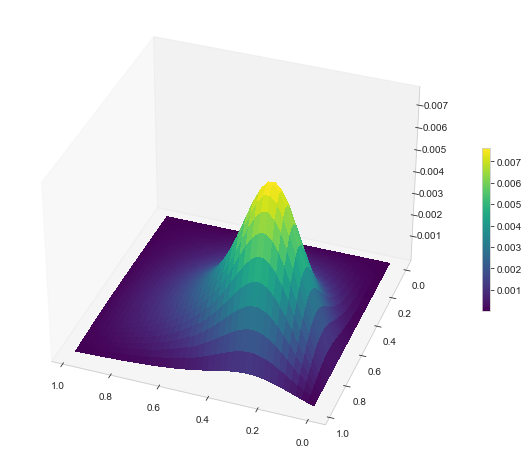

In [25]:
# surface plots of the true solution
_ = surface_plot(
    [0+tol, 1-tol], [0+tol, 1-tol], displacement, step=.025, angles=(35, 110))

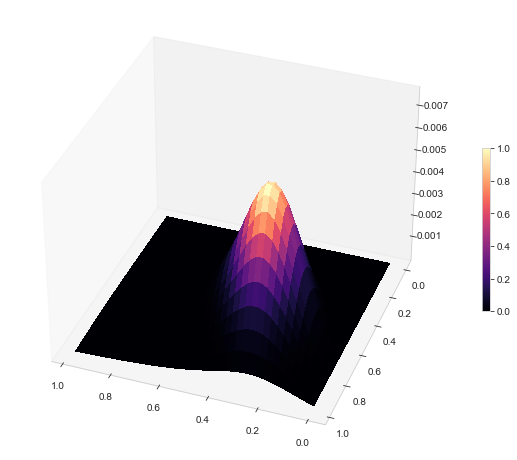

In [22]:
_ = surface_plot(
    [0+tol, 1-tol], [0+tol, 1-tol], displacement, step=.025, color_fun=pressure, angles=(35, 110))

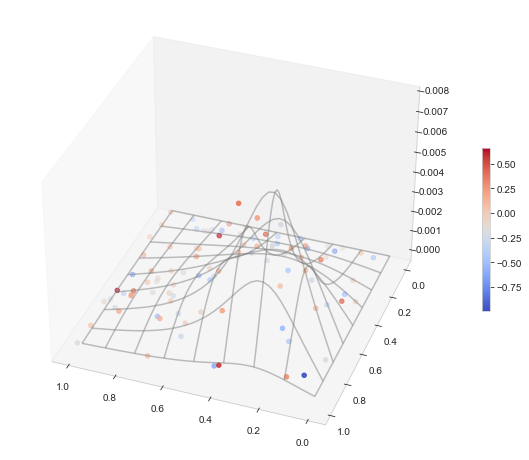

In [24]:
# wireframe plot of the solution with sampled data
fig, ax = wireframe_plot(
    [0+tol, 1-tol], [0+tol, 1-tol], displacement, step=.025, angles=(35, 110), show=False)
_ = points_plot(fig, ax, x, np.exp(data), color=noise)

Now we define the actual forward model that will be used during the MCMC.

In [26]:
# forward model for the MCMCs
forward_model = PoissonEquation(
    np.array([32, 32]), equation,
    np.array([.5, .5]), '0', reparam=True)

We set up the distributions that are going to be used in the MCMC.

In [27]:
# useful distributions and densities
def log_prior(z_):
    return -np.sum((z_ - prior_means) ** 2 / (2 * prior_sigmas ** 2))

prior = cpy.J(*[cpy.Normal(m, s) for m, s in zip(prior_means, prior_sigmas)])
log_err_density = GaussDensity(1.)
proposal = GaussDensity(proposal_sigma)
full_cnd_sigma2 = CondInvGamma(*gamma_parameters)

Here are the objects on which the MCMC is actually performed.

In [28]:
# models
hfm = HighFidelityModel(
    forward_model, data, x, log_err_density, log_prior)
lfm = PCESurrogate(data, log_err_density, prior, log_prior, 2, multi_fidelity_q)
gps = GPSurrogate(data, log_err_density, prior, log_prior, RBF(.1), multi_fidelity_q)

The following are some utility variables used to display properly the results.
Notice that if you wish to disable our very own gaussian process surrogate, you can do so by setting the variable
`use_gpr` to `False` at the beginning of this notebook.

In [29]:
if use_gpr:
    low_fi_models = [lfm, gps]
    surrogate_types = ['PCE', 'GPR']
else:
    low_fi_models = [lfm]
    surrogate_types = ['PCE']
method_names = ['true model (MH)'] + \
    ['{} surrogate (MH)'.format(typ) for typ in surrogate_types] + \
    ['{} surr. (adap. MH)'.format(typ) for typ in surrogate_types]

# remapping to the physical space
def inv_logit(x_):
    return 1./(1. + np.exp(-x_))

The following cell runs the MCMCs (depending on your system's specification, it should take somewhere between 5 and 10
minutes).

In [30]:
# running MCMCs
fit_times, fit_calls, exec_times, exec_calls, mh_samples = run_and_track(
    hfm, low_fi_models, quad_points,
    proposal, full_cnd_sigma2, init_z, init_sigma,
    samples, subchain_len, upper_th, error_th, init_radius, rho,
    remap_functions=[inv_logit, inv_logit, None])

AMH	100% |=============================| ETA:  00:00:00 - Elapsed Time: 0:00:30

Finally, the following shows some diagnostic plots of the chains.

In [31]:
# displaying results
diagnostics_report(
    method_names, exec_times, exec_calls, fit_times, fit_calls,
    len(low_fi_models), samples, burn, mh_samples)


performance evaluation:
────────────────────────────────────────────────────────────
	true model (MH):
		wall time: .................................. 360.10s
		(avg.) time per iteration: .................. 0.0072s
		effective sample size (min.): ............... 2836 / 50000
		true model eval.: ........................... 50001
────────────────────────────────────────────────────────────
	PCE surrogate (MH):
		wall time: .................................. 87.07s
		(avg.) time per iteration: .................. 0.0017s
		effective sample size (min.): ............... 3133 / 50000
		true model eval.: ........................... 0
		fitting time: ............................... 0.1215s
		true mod. eval. during fitting: ............. 9
────────────────────────────────────────────────────────────
	GPR surrogate (MH):
		wall time: .................................. 23.52s
		(avg.) time per iteration: .................. 0.0005s
		effective sample size (min.): ............... 3427 / 50000
		tru

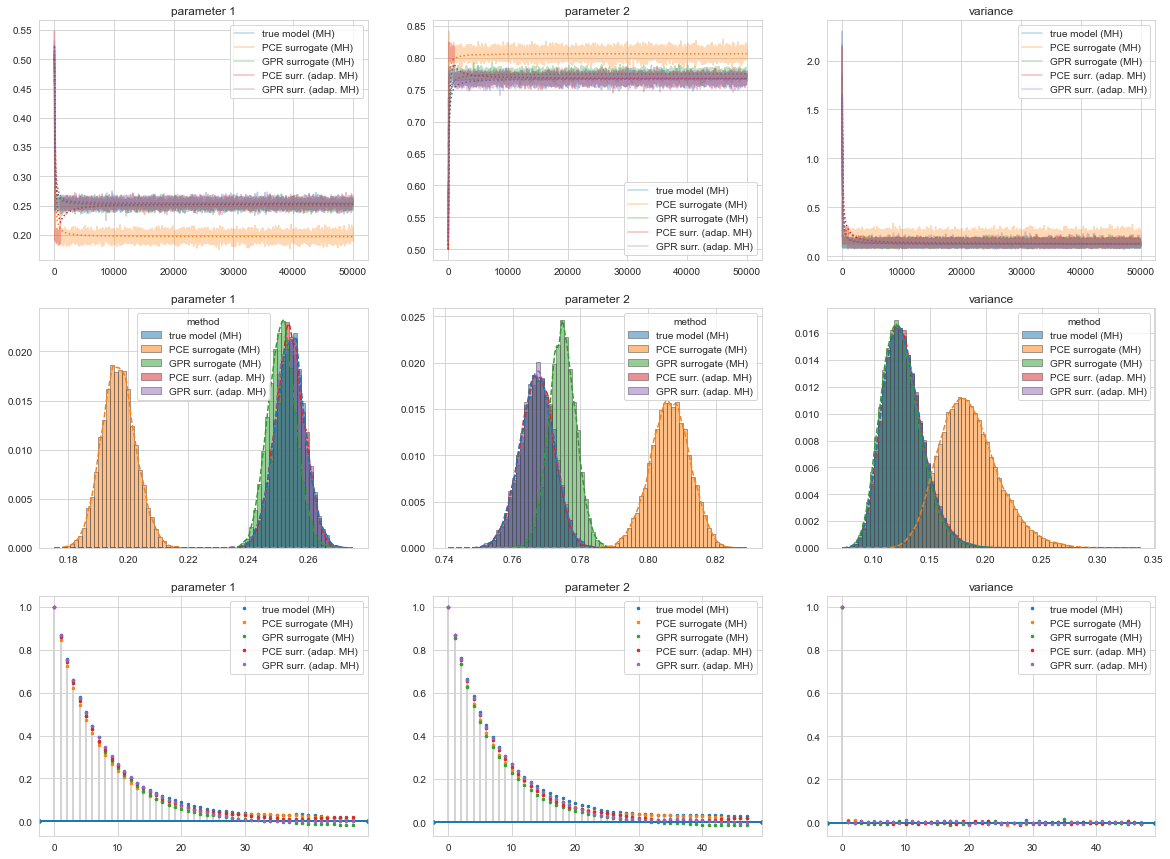

In [32]:
visual_inspection(dim, method_names, mh_samples, samples, burn)

